## SPI1 Design with BPNet

In this second tutorial we will look at doing SPI1 motif design using BPNet. Many of the steps in this tutorial will be the same as the DeepSEA/Beluga example. If you are looking for new content, scroll down to the end of the notebook.

From a design perspective, there are two compelling reasons to use a BPNet model: (1) they are trained solely on signal from one experiment and so cannot learn spurious correlations across cell types or tasks, and (2) a basepair resolution profile is being predicted so we can have additional control over the precise desire output. Both issues are weaknesses of the Beluga/DeepSEA models.

We will be using a PyTorch BPNet model trained using the bpnet-lite repo here. This library can be used to load up PyTorch versions of any of the BPNet models released, even those from the TensorFlow basepair models library.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch

model = torch.load("spi1.torch")
model

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

### Deleting SPI1

First, we will load up a locus that was found to have strong SPI1 binding. As before, we will use bpnet-lite for some simple processing scripts but it is not a requirement of Ledidi. Any library for one-hot encoding sequences is fine as long as the shape matches what is expected by the model.

In [2]:
import numpy
import pyfaidx
from bpnetlite.io import one_hot_encode

chrom, start, end = "chr6", 2880623, 2882737
mid = (start + end) // 2
start, end = mid - 1057, mid + 1057
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).cuda()

Unlike DeepSEA/Beluga, BPNet makes predictions for two different modalities: the profile head which is basepair resolution and the count head which is the total number of counts in the region. We will begin by designing edits using the count head since it is simpler to work with in this context. In order to extract the count predictions from the output, we will need to create a quick wrapper object that takes in a BPNet model and outputs only the count head. Because BPNet models require a control track input in addition to the sequence, this wrapper can have the additional convenience of passing in an all zeroes control. In general, creating wrappers around models can be a powerful way of using Ledidi to craft exactly the edits you want regardless of the output types of the predictive model.

In [3]:
class Wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, X):
        X_ctl = torch.zeros(X.shape[0], 2, X.shape[-1], dtype=X.dtype, device=X.device)
        return self.model(X, X_ctl)[1]

wrapper = Wrapper(model)
wrapper(X)

tensor([[4.0451]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

To confirm this is the case we can look at the attributions for the SPI1.

Populating the interactive namespace from numpy and matplotlib


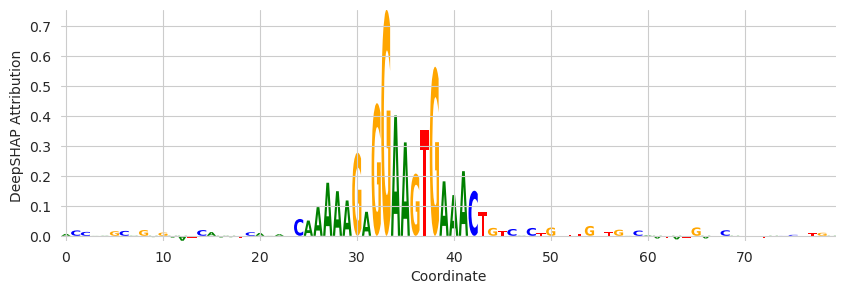

In [4]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

from captum.attr import DeepLiftShap

from bpnetlite.attributions import dinucleotide_shuffle
from bpnetlite.attributions import hypothetical_attributions
from bpnetlite.attributions import plot_attributions

references = dinucleotide_shuffle(X[0].cpu(), n_shuffles=20, random_state=0).cuda()

ig = DeepLiftShap(wrapper)
attr = ig.attribute(X, references, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0]

plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_attributions(attr[:, 1020:1100], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.show()

As expected, there is a strong SPI1 binding site driving the predictions.

Now, let's use Ledidi to design edits that will knock out SPI1 binding. To do this, we have to define a desired output from the model, `y_bar`. Since we are operating in log count space this should be zero. When setting this number, keep in mind that there is a trade-off between the output loss and the input loss. Even when you want to completely knock out signal, setting this value too low will cause Ledidi to make more edits than may be necessary to achieve the goal. Let's set it to 1 for now, which means going from ~54 counts to ~2.

In [5]:
from ledidi import Ledidi

torch.manual_seed(0)

y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 1

designer = Ledidi(wrapper, X.shape[1:], tau=0.1, l=1, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=9.273	total_loss=9.273
iter=0	input_loss=0.6562	output_loss=9.288	total_loss=9.945	time=0.09032
iter=1000	input_loss=1.375	output_loss=1.558	total_loss=2.933	time=8.542
iter=2000	input_loss=2.219	output_loss=0.09106	total_loss=2.31	time=8.501
iter=3000	input_loss=2.25	output_loss=0.1282	total_loss=2.378	time=8.498
iter=4000	input_loss=2.094	output_loss=0.04193	total_loss=2.136	time=8.455
iter=5000	input_loss=2.188	output_loss=0.02634	total_loss=2.214	time=8.462
iter=6000	input_loss=2.125	output_loss=0.1534	total_loss=2.278	time=8.471
iter=7000	input_loss=2.125	output_loss=0.02152	total_loss=2.147	time=8.483
iter=8000	input_loss=2.125	output_loss=0.0198	total_loss=2.145	time=8.476
iter=9000	input_loss=2.094	output_loss=0.08767	total_loss=2.181	time=8.473
iter=10000	input_loss= 2.0	output_loss=0.06047	total_loss=2.06	time=8.439


See how simple that was? Just a few lines of code and a small wrapper turns BPNet from a predictive model into a sequence editor.

Now, `X_hat` is not going to be a single sequence but rather a batch of randomly selected sequences from the iteration with the lowest `total_loss`. If no iterations have a lower `total_loss` than the initial iteration (I), the original sequence is returned.

We can score these sequences according to the number of edits made in each one as well as the model output, to see how close they got to the objective.

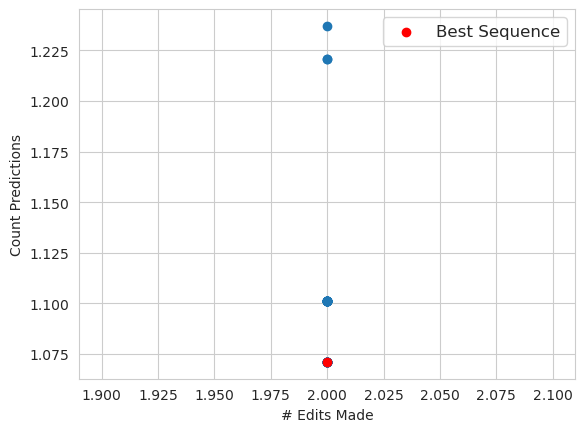

In [6]:
y_hat = wrapper(X_hat).cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)[:, 0]

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Count Predictions")
plt.show()

Looks like the best sequence made only a small number of edits and caused the predicted counts to go down to almost our desired output of 1.

We can take a look at the attribution scores again and check out whether the edits were made in high attribution sites.

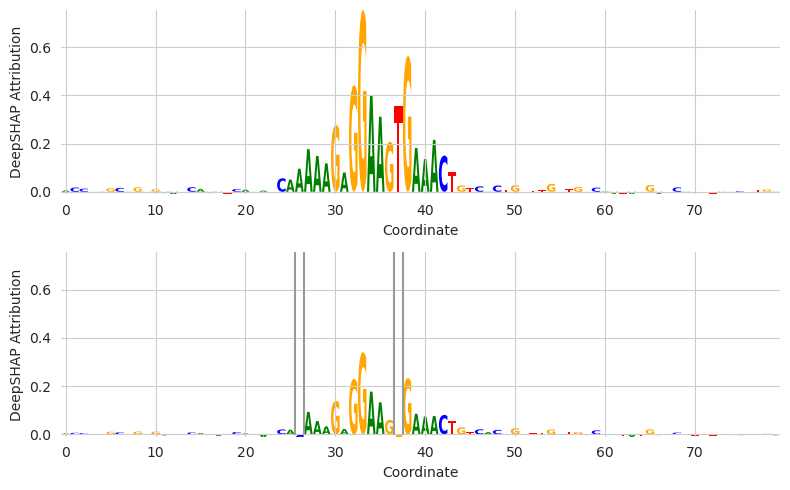

In [7]:
references = dinucleotide_shuffle(X_hat[best_idx].cpu(), n_shuffles=20, random_state=0).cuda()

ig = DeepLiftShap(wrapper)
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0]

start, end = 1020, 1100

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plot_attributions(attr[:, start:end], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.ylim(-0.01, attr.max())

ax = plt.subplot(212)
plot_attributions(attr_hat[:, start:end], ax=ax)
diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx, :].sum(axis=0) != 0)[0].cpu()

for idx in diff_idxs:
    if idx > start and idx < end:
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr.max()], color='0.6')
        
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.ylim(-0.01, attr.max())

plt.tight_layout()
plt.show()

Looks like two of the edits were made right in the middle of the binding site and knocked it down significantly.

If we want to create more sequences we can keep querying Ledidi.

In [8]:
X_hat = torch.cat([designer(X) for i in range(100)])
X_hat.shape

torch.Size([3200, 4, 2114])

Now we have 3200 sequences instead of 32.

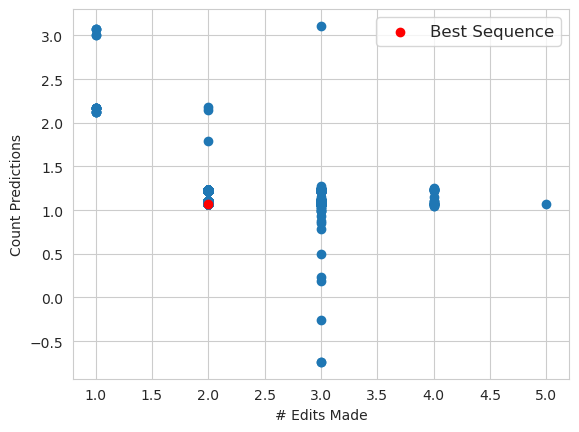

In [9]:
y_hat = wrapper(X_hat).cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)[:, 0]

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Count Predictions")
plt.show()

We can see way more diversity in these sequences! As more edits are made, sequences have closer to the desired logits of -2. 

### Adding in a motif

Next, let's look at trying to add in a SPI1 motif to a locus that normally does not exhibit SPI1 binding.

In [10]:
chrom, start, end = 'chr2', 1870500, 1872500
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).cuda()

y = wrapper(X)
y

tensor([[-0.4424]], device='cuda:0')

The only change we need to do to get Ledidi to try to add in a motif rather than delete a motif is have the desired output be positive instead of negative. As a technical note, you usually need to change the balance between the input loss and the output loss when moving from a motif deleting to a motif insertion task because one would expect there to be more edits when adding in activitity than simply deleting it. We do so here by just increasing `l` from 1 to 2.

In [11]:
torch.manual_seed(0)

y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 2

designer = Ledidi(wrapper, X.shape[1:], tau=0.1, l=2, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=5.965	total_loss=11.93
iter=0	input_loss= 0.5	output_loss=5.969	total_loss=12.44	time=0.07093
iter=1000	input_loss=0.375	output_loss=5.954	total_loss=12.28	time=8.528
iter=2000	input_loss=5.156	output_loss=0.3158	total_loss=5.788	time=8.49
iter=3000	input_loss=4.094	output_loss=0.2903	total_loss=4.674	time=8.47
iter=4000	input_loss=4.25	output_loss=0.2821	total_loss=4.814	time=8.48
iter=5000	input_loss=4.531	output_loss=0.2447	total_loss=5.021	time=8.48
iter=6000	input_loss=3.312	output_loss=0.1071	total_loss=3.527	time=8.495
iter=7000	input_loss=3.094	output_loss=0.1157	total_loss=3.325	time=8.475
iter=8000	input_loss=3.094	output_loss=0.1181	total_loss=3.33	time=8.475
iter=9000	input_loss=3.156	output_loss=0.1159	total_loss=3.388	time=8.521
iter=10000	input_loss= 3.0	output_loss=0.1186	total_loss=3.237	time=8.527


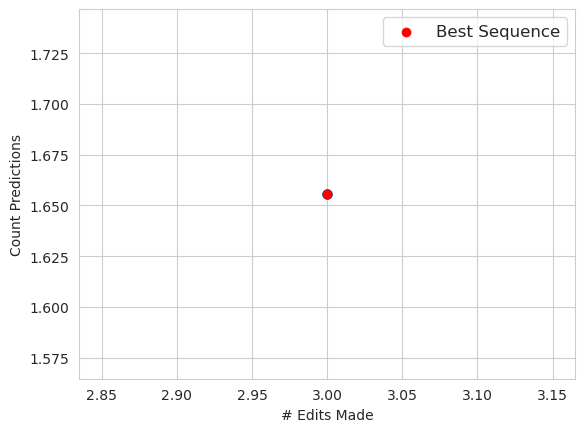

In [12]:
y_hat = wrapper(X_hat).cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)[:, 0]

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Count Predictions")
plt.show()

Similarly to the motif deletion setting we can see that more edits means getting closer to the goal. However, the best chosen identified sequence is not the one with highest logit just due to the balance between the number of edits and small improvement in the logit.

Let's take a look at the edits made.

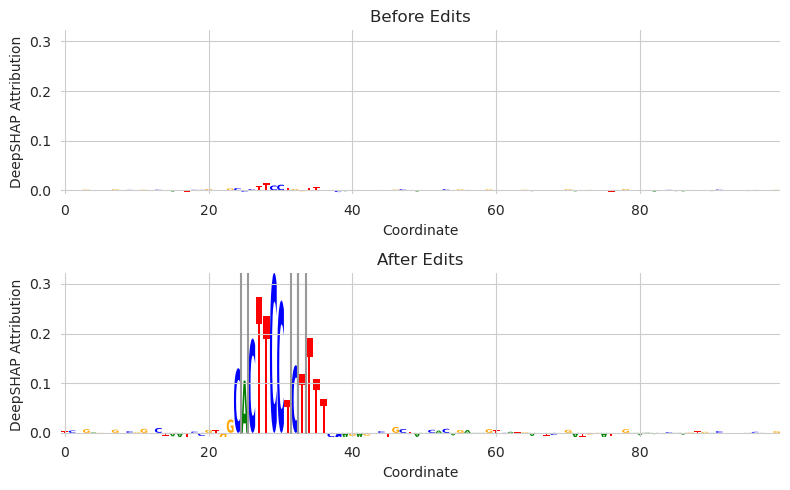

In [13]:
ig = DeepLiftShap(wrapper)

references = dinucleotide_shuffle(X[0].cpu(), n_shuffles=20, random_state=0).cuda()
attr = ig.attribute(X, references, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0]

references = dinucleotide_shuffle(X_hat[best_idx].cpu(), n_shuffles=20, random_state=0).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 600, 700

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

We can see that, initially, there is only low attribution for all the nucleotides. After making the changes we can see that some spans are starting to achieve high attribution! Unlike the Beluga example, the BPNet model is much more focused on SPI1 and so adds in the correct motif.

You may be surprised by the low number of edits needed to successfully cause binding. After all, if a motif is ~7 nucleotides long, it should take that many edits, right? Well, no. Ledidi finds regions on the genome that are already almost the binding motif and will usually just edit a few nucleotides to get a good match.

### Controlled design: inputs

Ledidi is extremely flexible and there are several ways to control the design process. The simplest is to alter the initial weight matrix that Ledidi uses instead of having it be all zeroes. For example, let's return to the deletion example but focus on an array of SPI1 binding sites found at another locus.

In [14]:
chrom, start, end = "chr1", 4006640, 4008754
mid = (start + end) // 2
start, end = mid - 1057, mid + 1057
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).cuda()

y = wrapper(X)
y

tensor([[8.6324]], device='cuda:0')

This region has extremely high predicted SPI1 binding. If we visualize the attributions we can see why.

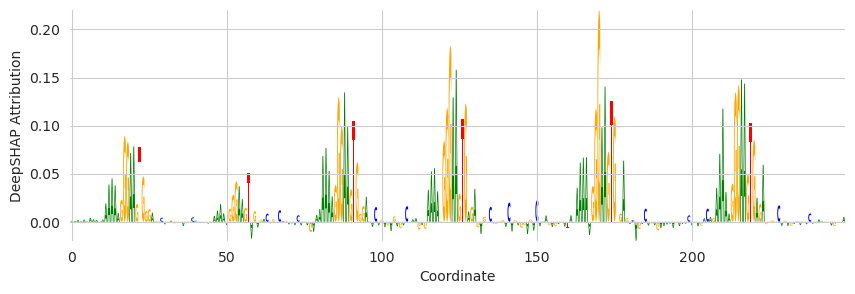

In [15]:
references = dinucleotide_shuffle(X[0].cpu(), n_shuffles=20, random_state=0).cuda()

ig = DeepLiftShap(wrapper)
attr = ig.attribute(X, references, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0]

plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
plot_attributions(attr[:, 925:1175], ax=ax)
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")
plt.show()

There is a whole array of SPI1 binding sites here! Let's say that we wanted to decrease binding by a controlled amount and figured that the left two motifs should be edited but didn't know the exact edits or which one would be best. We can set up a mask to only allow edits in the first 60bp of this visualized locus. In this case we want to lower binding from 8.6 to 7.

In [16]:
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 7
input_mask = torch.ones(2114, dtype=torch.bool, device='cuda')
input_mask[925:985] = False

designer = Ledidi(wrapper, X.shape[1:], tau=1, l=10, input_mask=input_mask, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=2.665	total_loss=26.65
iter=0	input_loss= 0.0	output_loss=2.667	total_loss=26.67	time=0.003229
iter=1000	input_loss=7.031	output_loss=1.535	total_loss=22.38	time=8.625
iter=2000	input_loss=7.25	output_loss=1.487	total_loss=22.12	time=8.651
iter=3000	input_loss=7.125	output_loss=1.475	total_loss=21.87	time=8.66
iter=4000	input_loss=6.812	output_loss=1.525	total_loss=22.06	time=8.652
iter=5000	input_loss=7.594	output_loss=1.453	total_loss=22.12	time=8.646
iter=6000	input_loss=7.594	output_loss=1.428	total_loss=21.87	time=8.643
iter=7000	input_loss= 7.0	output_loss=1.446	total_loss=21.46	time=8.641
iter=8000	input_loss=7.469	output_loss=1.454	total_loss=22.01	time=8.632
iter=9000	input_loss=7.281	output_loss=1.456	total_loss=21.84	time=8.605
iter=10000	input_loss=7.094	output_loss=1.458	total_loss=21.68	time= 8.6


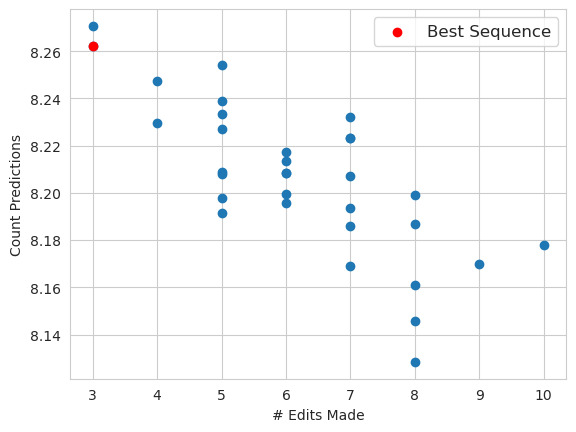

In [17]:
y_hat = wrapper(X_hat).cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)[:, 0]

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Count Predictions")
plt.show()

It looks like all of the samples sequences are producing the same edit! But the goal did not seem to really be achieved -- the logit is still pretty positive. This is probably due to the very constrained nature of the design task. Let's take a look at what nucleotide got edited.

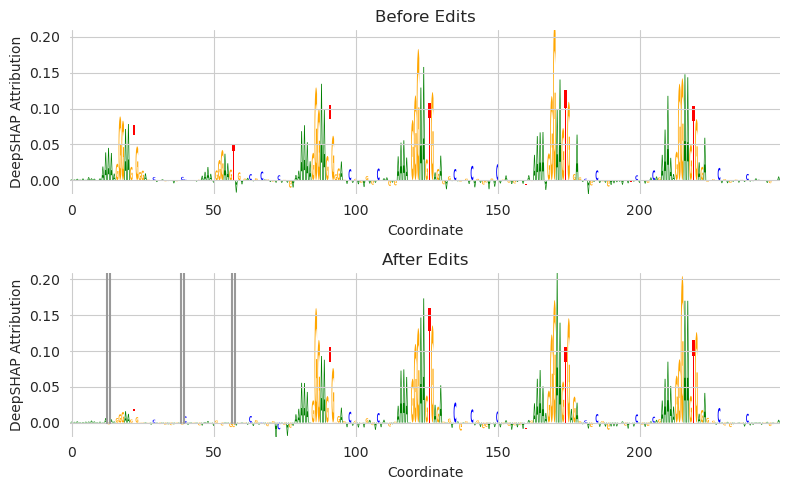

In [18]:
ig = DeepLiftShap(wrapper)

references = dinucleotide_shuffle(X[0].cpu(), n_shuffles=20, random_state=0).cuda()
attr = ig.attribute(X, references, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0]

references = dinucleotide_shuffle(X_hat[best_idx].cpu(), n_shuffles=20, random_state=0).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 925, 1175

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

Looks like we were able to knock out the binding of those two sites.

In [19]:
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 7
input_mask = torch.ones(2114, dtype=torch.bool, device='cuda')
input_mask[985:1150] = False

designer = Ledidi(wrapper, X.shape[1:], tau=1, l=10, input_mask=input_mask, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=2.665	total_loss=26.65
iter=0	input_loss=0.0625	output_loss=2.686	total_loss=26.92	time=0.003127
iter=1000	input_loss=10.06	output_loss=0.1554	total_loss=11.62	time=8.644
iter=2000	input_loss=12.28	output_loss=0.08852	total_loss=13.17	time=8.656
iter=3000	input_loss=13.03	output_loss=0.1375	total_loss=14.41	time=8.648
iter=4000	input_loss=13.34	output_loss=0.05241	total_loss=13.87	time=8.646
iter=5000	input_loss=11.41	output_loss=0.04802	total_loss=11.89	time=8.64
iter=6000	input_loss=11.53	output_loss=0.04515	total_loss=11.98	time=8.651
iter=7000	input_loss=11.72	output_loss=0.06077	total_loss=12.33	time=8.646
iter=8000	input_loss=10.75	output_loss=0.05583	total_loss=11.31	time=8.653
iter=9000	input_loss=10.78	output_loss=0.04623	total_loss=11.24	time=8.656
iter=10000	input_loss=10.75	output_loss=0.05902	total_loss=11.34	time=8.636


Ledidi has the ability to edit any of the first 40 nucleotides in this sequence. As expected, it ended up making one edit within the AP-1 site and completely knocked it out!

Now, what happens when we limit edits to the next 40 nucleotides?

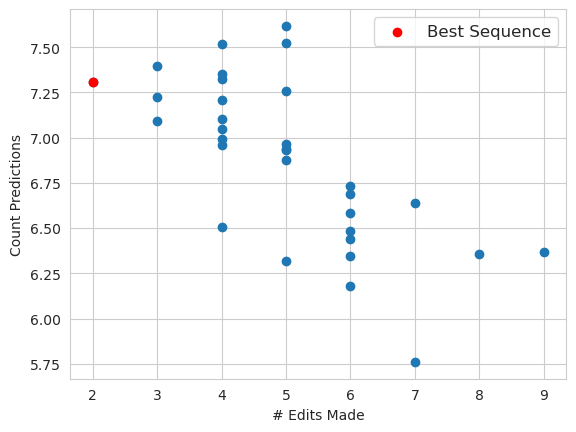

In [20]:
y_hat = wrapper(X_hat).cpu().detach().numpy()

input_loss = torch.abs(X_hat - X).sum(axis=(1, 2)).cpu().detach().numpy() // 2
output_loss = numpy.square(y_bar.cpu().detach().numpy() - y_hat)[:, 0]

best_idx = numpy.argmin(input_loss + designer.l * output_loss)

plt.scatter(input_loss, y_hat)
plt.scatter(input_loss[best_idx], y_hat[best_idx], c='r', label="Best Sequence")
plt.legend(fontsize=12)
plt.xlabel("# Edits Made")
plt.ylabel("Count Predictions")
plt.show()

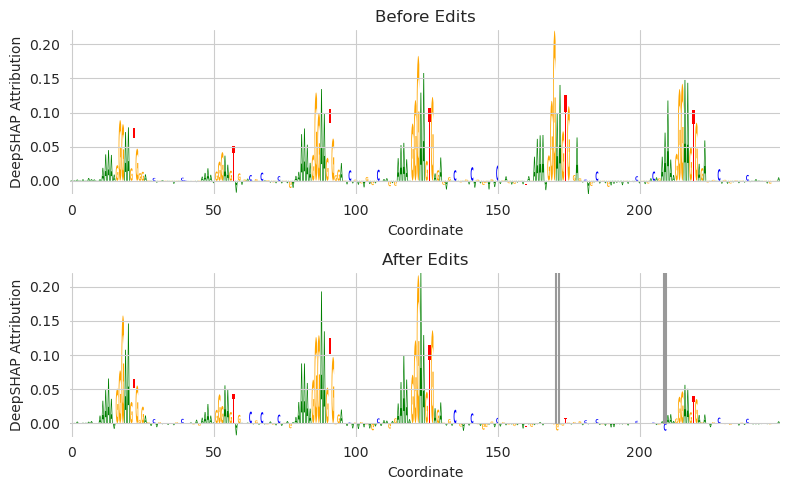

In [21]:
ig = DeepLiftShap(wrapper)

references = dinucleotide_shuffle(X[0].cpu(), n_shuffles=20, random_state=0).cuda()
attr = ig.attribute(X, references, custom_attribution_func=hypothetical_attributions)
attr = (attr * X).cpu().detach().numpy()[0]

references = dinucleotide_shuffle(X_hat[best_idx].cpu(), n_shuffles=20, random_state=0).cuda()
attr_hat = ig.attribute(X_hat[best_idx:best_idx+1], references, custom_attribution_func=hypothetical_attributions)
attr_hat = (attr_hat * X_hat[best_idx]).cpu().detach().numpy()[0]

diff_idxs = torch.where(torch.abs(X_hat - X)[best_idx].sum(axis=0) != 0)[0].cpu().numpy()

start, end = 925, 1175

plt.figure(figsize=(8, 5))
ax = plt.subplot(211)
plt.title("Before Edits", fontsize=12)
plot_attributions(attr[:, start:end], ax=ax)
plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

ax = plt.subplot(212)
plt.title("After Edits", fontsize=12)
plot_attributions(attr_hat[:, start:end], ax=ax)

for idx in diff_idxs:
    if idx > start and idx < end:        
        plt.plot([idx-start-0.5, idx-start-0.5], [0, attr_hat.max()], color='0.6')
        plt.plot([idx-start+0.5, idx-start+0.5], [0, attr_hat.max()], color='0.6')

plt.ylim(attr.min(), attr_hat.max())
plt.xlabel("Coordinate")
plt.ylabel("DeepSHAP Attribution")

plt.tight_layout()
plt.show()

Interestingly, in order to get to the desired value of 7 it has to make precise edits. The middle motif is almost completely knocked out, the next one to the right is weakened, and the third one is only valuely changed. The third motif from the left is not touched. No other edits are made to the sequence. 

### Controlled design: Outputs

Another way that design can be controlled is by designing a clever wrapper that only considers some outputs. In the case of BPNet, we can try to design sequences whose profiles have very specific characteristics. Let's consider this in the setting of inserting a SPI1 motif.

In [22]:
chrom, start, end = 'chr2', 1870500, 1872614
seq = pyfaidx.Fasta("hg38.fa")[chrom][start:end].seq.upper()

X = one_hot_encode(seq).T.astype(numpy.float32)
X = torch.from_numpy(X).unsqueeze(0).cuda()

y = wrapper(X)
y

tensor([[-0.2818]], device='cuda:0')

We need a new wrapper that focused on the profile head instead of the count head and returns the sum under a slice of the profile. Given that the sum across the entire profile is 1, we can use this to control where we want the density to be in the profile.

In [23]:
class ProfileWrapper(torch.nn.Module):
    def __init__(self, model, start=0, end=-1):
        super().__init__()
        self.model = model
        self.start = start
        self.end = end
    
    def forward(self, X):
        X_ctl = torch.zeros(X.shape[0], 2, X.shape[-1], dtype=X.dtype, device=X.device)
        
        y = self.model(X, X_ctl)[0]
        y = torch.nn.functional.softmax(y.reshape(y.shape[0], -1), dim=-1).reshape(*y.shape)
        y = y[:, :, self.start:self.end].sum(dim=(1, 2))
        return y.unsqueeze(1)

Now, we can say that we want as much of the predicted density as possible to be under the span of nucleotides 200-400 in the output window.

In [24]:
torch.manual_seed(0)

wrapper = ProfileWrapper(model, 200, 400)
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 1

designer = Ledidi(wrapper, X.shape[1:], tau=0.1, l=10, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=0.8353	total_loss=8.353
iter=0	input_loss=0.875	output_loss=0.8348	total_loss=9.223	time=0.00334
iter=1000	input_loss=0.2188	output_loss=0.8352	total_loss=8.571	time=9.281
iter=2000	input_loss=1.875	output_loss=0.7206	total_loss=9.081	time=9.191
iter=3000	input_loss=1.25	output_loss=0.6834	total_loss=8.084	time=9.184
iter=4000	input_loss=1.125	output_loss=0.6838	total_loss=7.963	time=9.185
iter=5000	input_loss=2.156	output_loss=0.6286	total_loss=8.442	time=9.182
iter=6000	input_loss=2.188	output_loss=0.6282	total_loss=8.469	time=9.199
iter=7000	input_loss=4.094	output_loss=0.2416	total_loss=6.509	time=9.181
iter=8000	input_loss= 4.0	output_loss=0.2413	total_loss=6.413	time=9.189
iter=9000	input_loss=4.094	output_loss=0.2413	total_loss=6.507	time=9.22
iter=10000	input_loss=4.062	output_loss=0.2392	total_loss=6.454	time=9.204


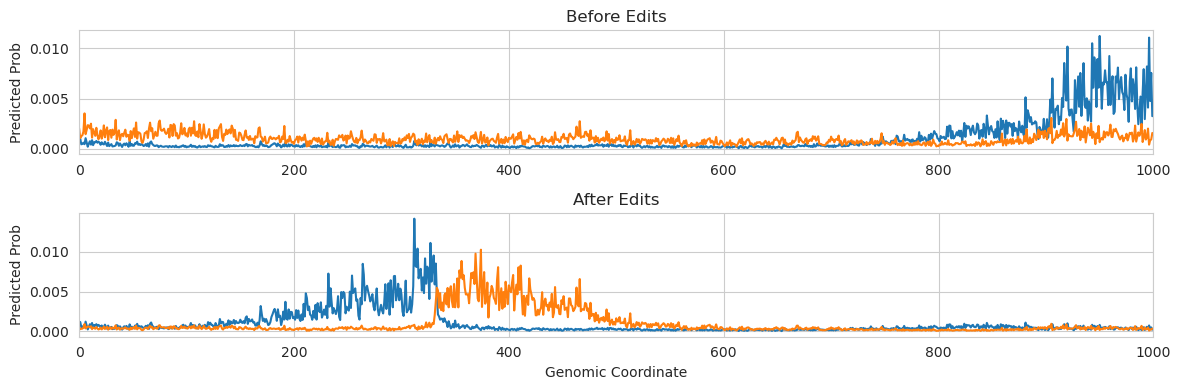

In [25]:
X_ctl = torch.zeros(1, 2, 2114).cuda()

y = model(X, X_ctl)[0][0]
y = torch.nn.functional.softmax(y.reshape(y.shape[0], -1), dim=-1).reshape(*y.shape).numpy(force=True)

y_hat = model(X_hat, X_ctl.expand(32, -1, -1))[0][0]
y_hat = torch.nn.functional.softmax(y_hat.reshape(y.shape[0], -1), dim=-1).reshape(*y.shape).numpy(force=True)

plt.figure(figsize=(12, 4))
plt.subplot(211)
plt.title("Before Edits")
plt.plot(y.T)
plt.ylabel("Predicted Prob")
plt.xlim(0, 1000)

plt.subplot(212)
plt.title("After Edits")
plt.plot(y_hat.T)
plt.ylabel("Predicted Prob")
plt.xlabel("Genomic Coordinate")
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

Or, we can try to have as much of it happen between 600 and 800.

In [26]:
torch.manual_seed(0)

wrapper = ProfileWrapper(model, 600, 800)
y_bar = torch.zeros(1, dtype=torch.float32, device='cuda') + 1

designer = Ledidi(wrapper, X.shape[1:], tau=0.1, l=10, max_iter=10000, report_iter=1000).cuda()
X_hat = designer.fit_transform(X, y_bar)

iter=I	input_loss=0	output_loss=0.8055	total_loss=8.055
iter=0	input_loss=0.875	output_loss=0.8054	total_loss=8.929	time=0.003075
iter=1000	input_loss=0.1875	output_loss=0.8055	total_loss=8.243	time=9.218
iter=2000	input_loss=0.1875	output_loss=0.8056	total_loss=8.243	time=9.243
iter=3000	input_loss=1.219	output_loss=0.6914	total_loss=8.133	time=9.22
iter=4000	input_loss=1.125	output_loss=0.688	total_loss=8.005	time=9.222
iter=5000	input_loss=2.156	output_loss=0.5578	total_loss=7.734	time=9.209
iter=6000	input_loss=2.219	output_loss=0.5573	total_loss=7.792	time=9.212
iter=7000	input_loss=2.094	output_loss=0.5583	total_loss=7.677	time=9.211
iter=8000	input_loss=3.969	output_loss=0.1886	total_loss=5.855	time=9.21
iter=9000	input_loss=4.094	output_loss=0.1843	total_loss=5.937	time=9.215
iter=10000	input_loss= 4.0	output_loss=0.1677	total_loss=5.677	time=9.198


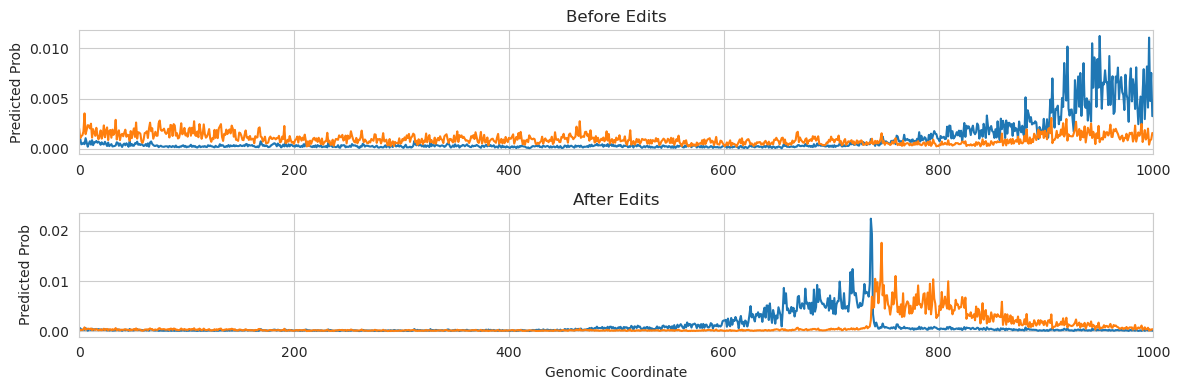

In [27]:
X_ctl = torch.zeros(1, 2, 2114).cuda()

y = model(X, X_ctl)[0][0]
y = torch.nn.functional.softmax(y.reshape(y.shape[0], -1), dim=-1).reshape(*y.shape).numpy(force=True)

y_hat = model(X_hat, X_ctl.expand(32, -1, -1))[0][0]
y_hat = torch.nn.functional.softmax(y_hat.reshape(y.shape[0], -1), dim=-1).reshape(*y.shape).numpy(force=True)

plt.figure(figsize=(12, 4))
plt.subplot(211)
plt.title("Before Edits")
plt.plot(y.T)
plt.ylabel("Predicted Prob")
plt.xlim(0, 1000)

plt.subplot(212)
plt.title("After Edits")
plt.plot(y_hat.T)
plt.ylabel("Predicted Prob")
plt.xlabel("Genomic Coordinate")
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()